训练rmse: 0.003197


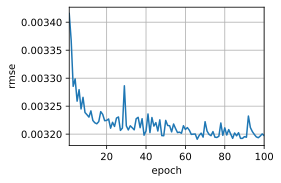

In [9]:
#matplotblib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
## test
print("在公司测试")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 128),
                        nn.ReLU(),
                        nn.Linear(128,1),
                        nn.Sigmoid()
                )
    # return net
    return net.to(device)

def log_rmse(net, features, labels):
    clipped_preds = net(features)
    # rmse = torch.sqrt(loss(clipped_preds,labels))
    rmse = loss(clipped_preds,labels)
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay=weight_decay)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[1, num_epochs], ylim=[0, 0.004])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        animator.add(epoch + 1, (log_rmse(net, train_features, train_labels)))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay,
                                   batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        
        print(f'折{i + 1},训练 rmse {float(train_ls[-1]):f}, '
              f'验证 rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', xlim=[1, num_epochs])
    print(f'训练rmse: {float(train_ls[-1]):f}')
    # preds = net(test_features).detach().numpy()
    preds = net(test_features).detach().cpu().numpy()
    test_data['accident_risk'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['id'], test_data['accident_risk']], axis = 1)
    submission.to_csv('D:/kaggle/data/accidentrisk/submission.csv', index=False)

train_data = pd.read_csv('D:/kaggle/data/accidentrisk/train.csv')
test_data = pd.read_csv('D:/kaggle/data/accidentrisk/test.csv')

all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

all_features = pd.get_dummies(all_features, dummy_na=True).astype('float32')

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train::].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.accident_risk.values.reshape(-1,1), dtype=torch.float32
)

loss = nn.MSELoss()
in_features = train_features.shape[1]

train_features = train_features.to(device)
test_features  = test_features.to(device)
train_labels   = train_labels.to(device)

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1e-3, 0, 256
# train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
#                           weight_decay, batch_size)

# print(f'{k}-折验证: 平均训练 rmse: {float(train_l):f}, 'f'平均验证 rmse: {float(valid_l):f}')
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
